In [31]:
# import libraries
import pandas as pd
import string
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from nltk.tokenize import word_tokenize
import plotly.express as px
from plotly.offline import init_notebook_mode
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import spacy

tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# import data from google drive
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/BT5151 + BT5153 /BT5153 - Fake Review Detection/fake reviews dataset.csv')
df.head(3)

Mounted at /content/drive


,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...


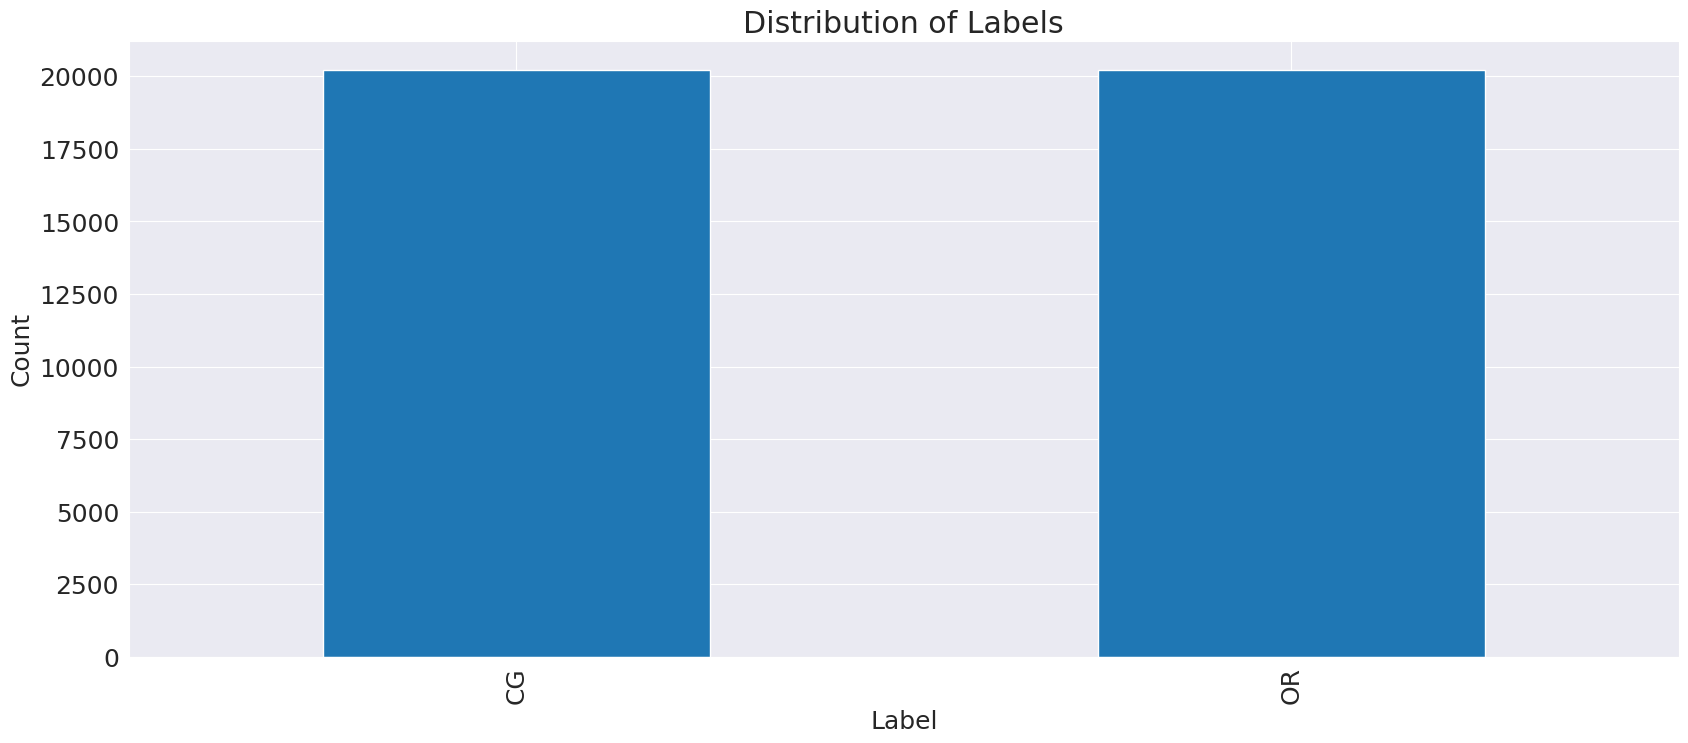

In [6]:
# Distribution of labels
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

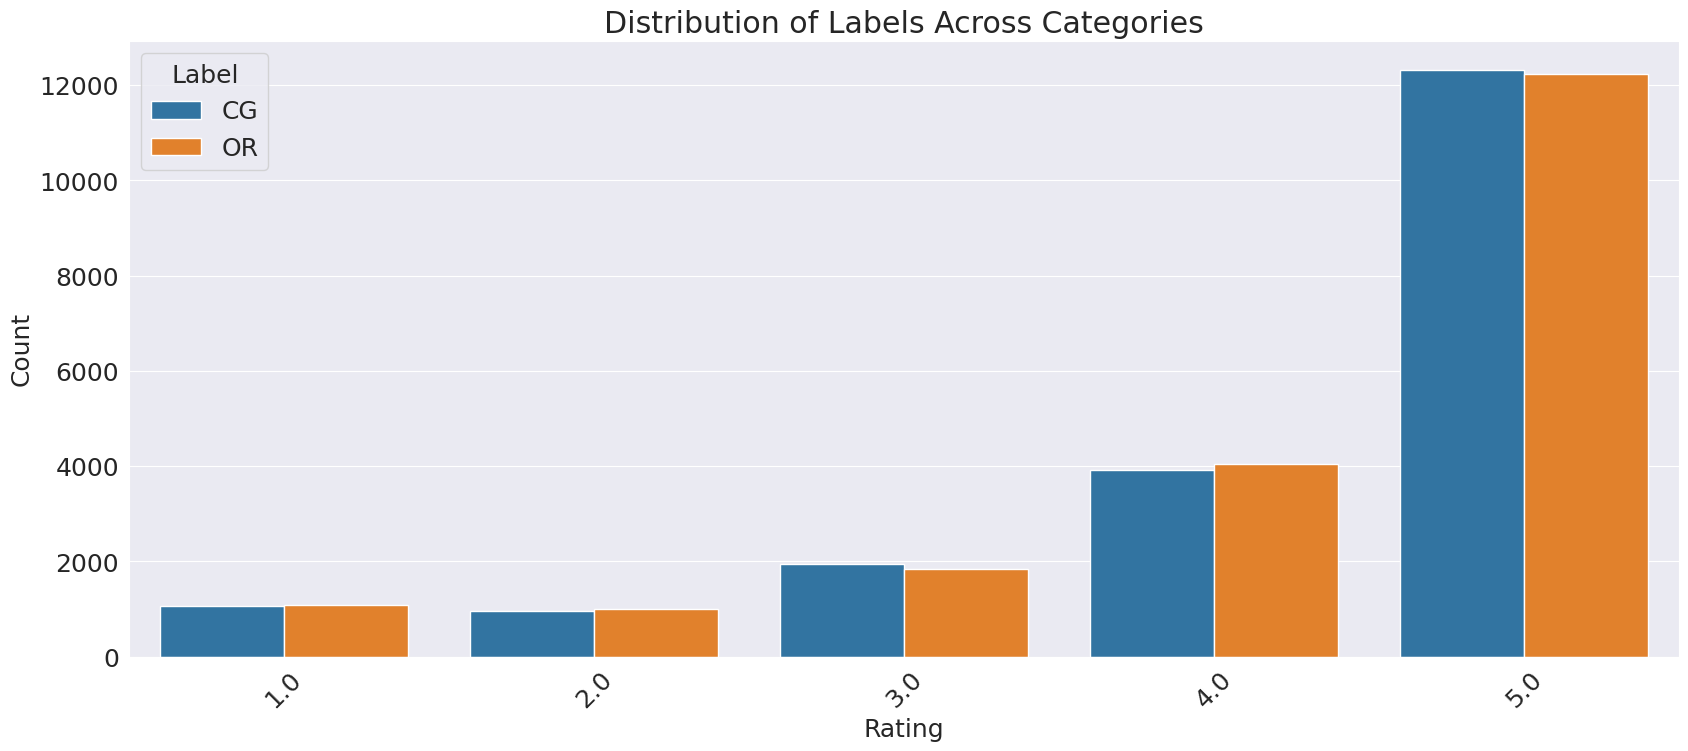

In [34]:
# Distribution of labels across ratings
sns.countplot(data=df, x='rating', hue='label')
plt.title('Distribution of Labels Across Categories')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Label')
plt.xticks(rotation=45)
plt.show()

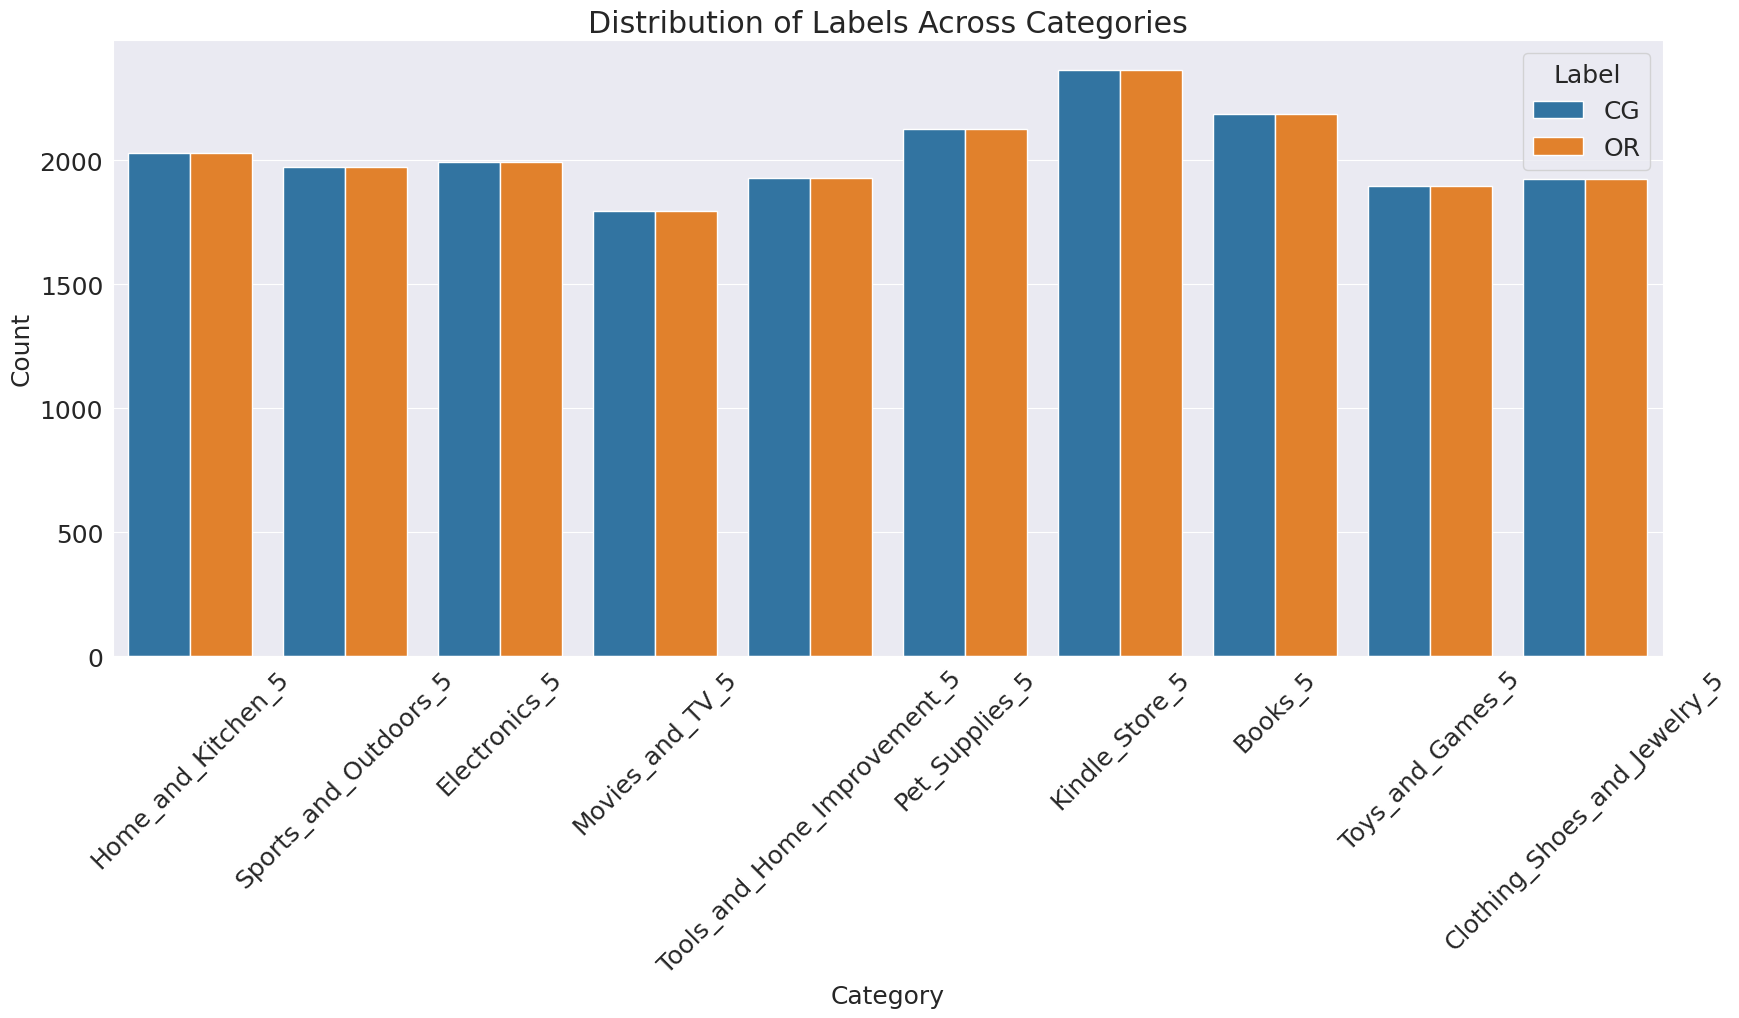

In [9]:
# Distribution of labels across categories
sns.countplot(data=df, x='category', hue='label')
plt.title('Distribution of Labels Across Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='Label')
plt.xticks(rotation=45)
plt.show()

In [13]:
# Count the number of words for each review
df['text_length'] = df['text_'].apply(len)

# Statistics for text length across labels
df.groupby('label')['text_length'].agg(['min', 'max', 'mean', 'std'])

,min,max,mean,std
label,,,,
CG,24,1717,305.573506,307.037430
OR,28,2827,396.970419,418.428047


In [15]:
# Overall statistics for text length
df['text_length'].agg(['min', 'max', 'mean', 'std'])

min       24.000000
max     2827.000000
mean     351.271963
std      369.813570
Name: text_length, dtype: float64

Top 20 words for label 'CG':
.: 93021
I: 62600
the: 61939
a: 56358
and: 43089
is: 40467
it: 36392
to: 30553
,: 28912
The: 21771
this: 21051
of: 20330
for: 20210
was: 14743
very: 14133
have: 13446
that: 12457
in: 10985
with: 10751
's: 10413


Top 20 words for label 'OR':
.: 90250
the: 63771
,: 50805
and: 43456
I: 43226
a: 38842
to: 37629
it: 28439
of: 24943
is: 24665
for: 17944
in: 17720
this: 16957
that: 14481
with: 12524
was: 12007
my: 11027
on: 10694
but: 10564
!: 10502




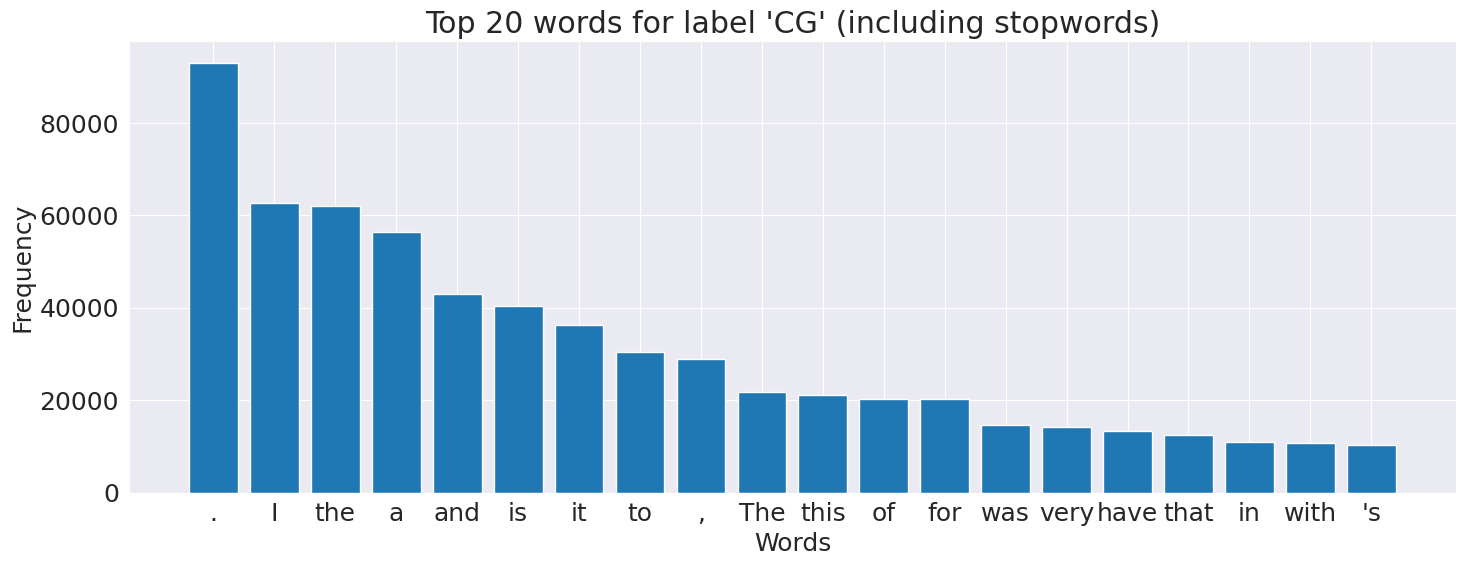

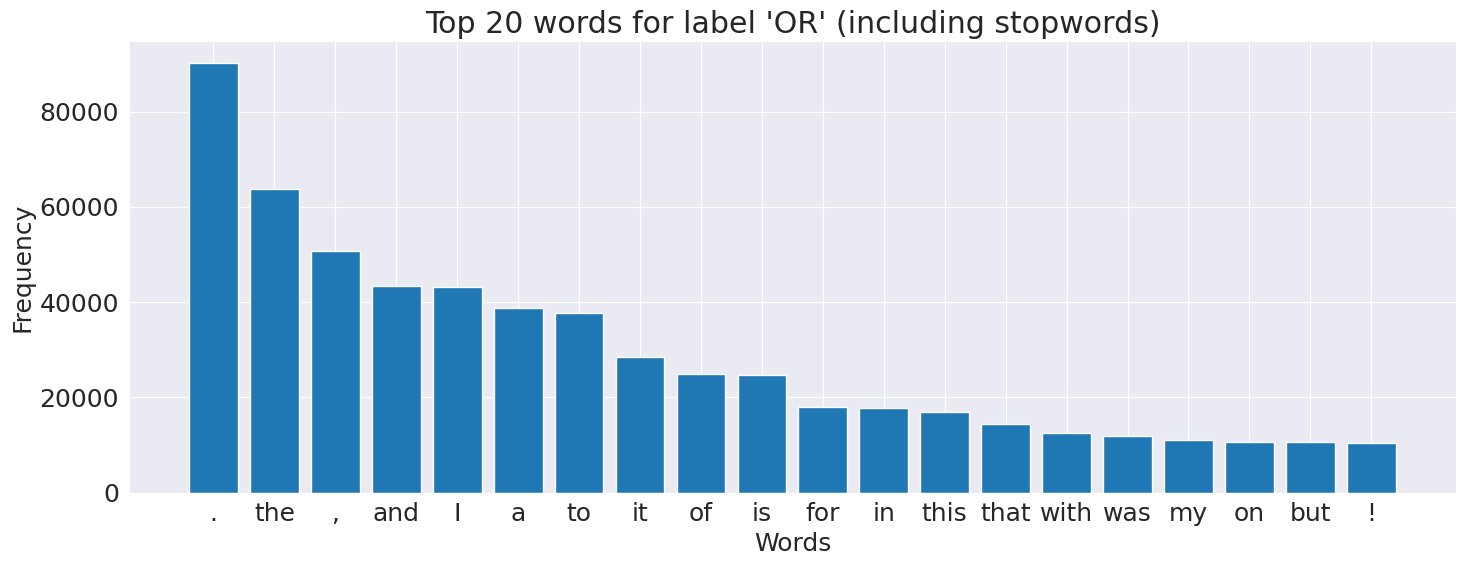

In [27]:
# Count Top 20 frequency words including stopwords
# Tokenize the text
df['tokens'] = df['text_'].apply(word_tokenize)

# Function to get the top 20 frequency words for each label
def top_words_per_label(label):
    label_df = df[df['label'] == label]
    words = [word for sublist in label_df['tokens'] for word in sublist]
    word_freq = Counter(words)
    top_words = word_freq.most_common(20)
    return top_words

# Get top 20 frequency words for each label
labels = df['label'].unique()
top_words_per_label_dict = {label: top_words_per_label(label) for label in labels}

# Print top 20 frequency words for each label
for label, top_words in top_words_per_label_dict.items():
    print(f"Top 20 words for label '{label}':")
    for word, freq in top_words:
        print(f"{word}: {freq}")
    print("\n")

def visualize_top_words(top_words_per_label_dict):
    for label, top_words in top_words_per_label_dict.items():
        words, freqs = zip(*top_words)
        plt.figure(figsize=(15, 6))
        plt.bar(words, freqs)
        plt.title(f"Top 20 words for label '{label}' (including stopwords)")
        plt.xlabel("Words")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# Call the function to visualize top words for each label
visualize_top_words(top_words_per_label_dict)

Top 20 words for label 'CG':
great: 11434
book: 10111
good: 9578
love: 6973
story: 6834
well: 6476
would: 6045
read: 5893
little: 5319
recommend: 4835
characters: 4717
movie: 4242
like: 4194
bought: 3995
loves: 3639
small: 3537
nice: 3433
also: 3362
easy: 3102
size: 2976


Top 20 words for label 'OR':
great: 5824
like: 5302
book: 5290
good: 4787
well: 4396
would: 4376
love: 3977
really: 3540
read: 3305
time: 2957
story: 2910
much: 2871
little: 2833
also: 2370
first: 2178
even: 2124
product: 2083
work: 1982
made: 1974
nice: 1933




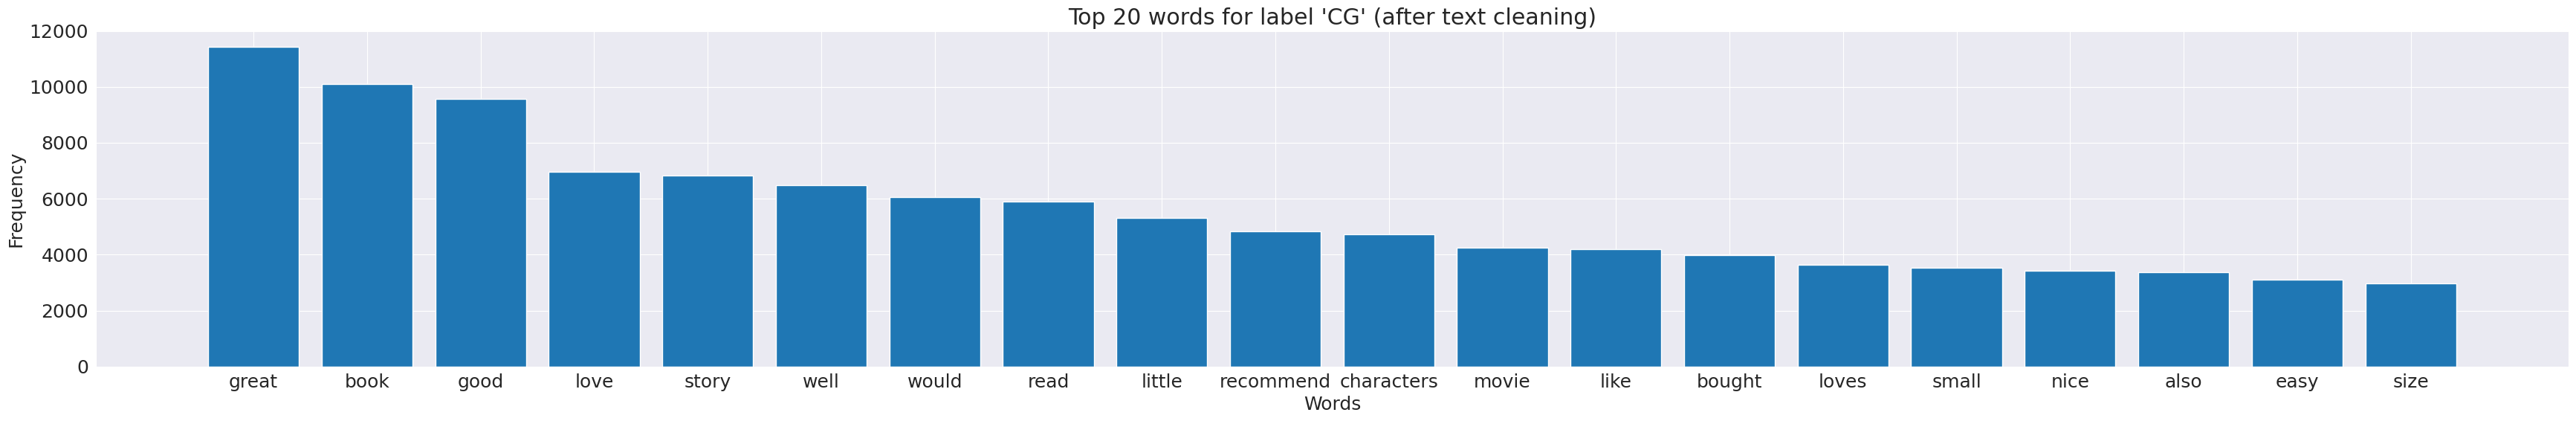

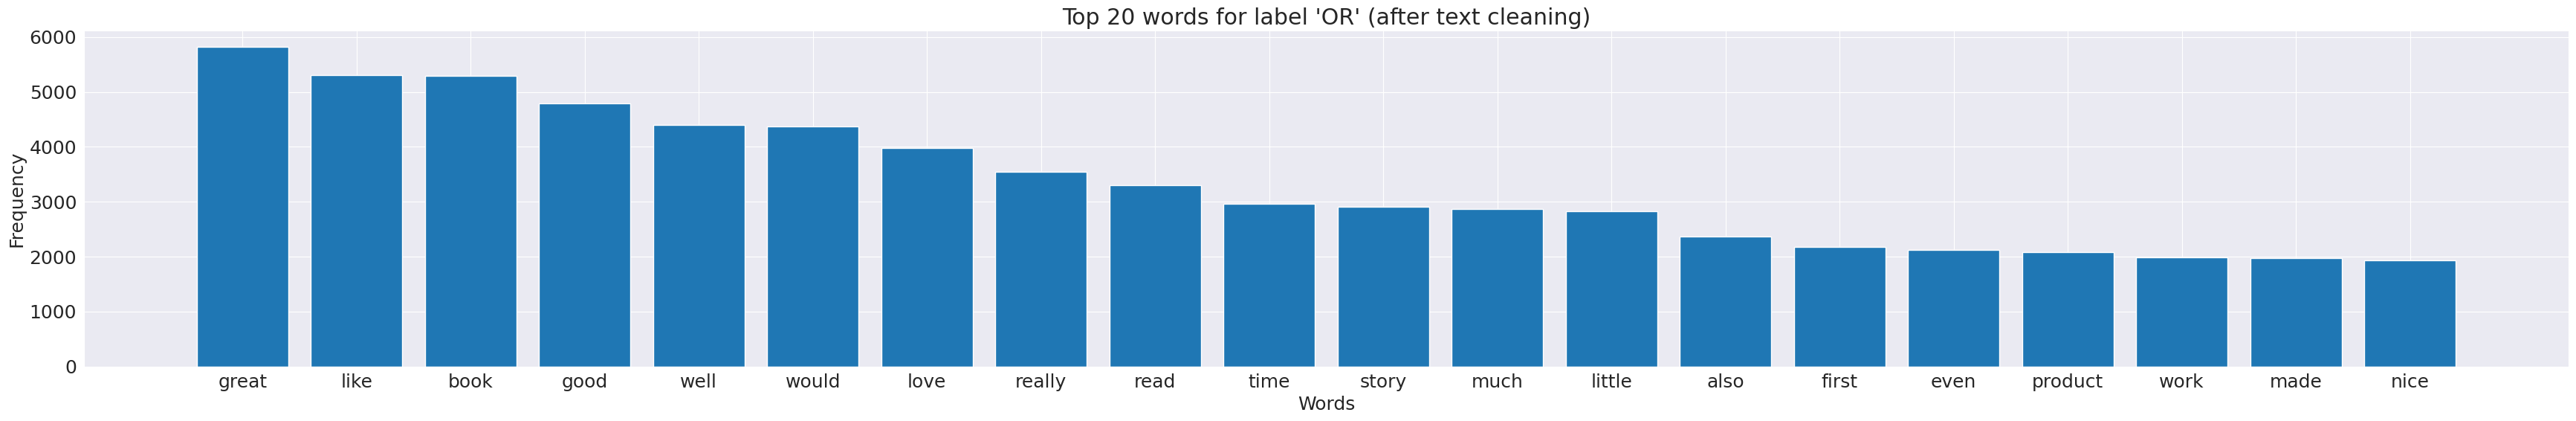

In [39]:
# Define stopwords and punctuation
stop_words = set(stopwords.words("english"))
stop_words.update([ "br", "href", "n't", "'s'", "counter", "``"])
punctuation = set(string.punctuation)

def Clean_Text(review):
    # Remove links
    review = re.sub(r'https?:\S*', '', review)
    review = re.sub(r'{link}', '', review)

    # Remove mentions
    review = re.sub(r'@[\w]*', '', review)

    # Remove non-alphanumeric characters
    review = re.sub(r'[^A-Za-z0-9]+', ' ', review)

    # Remove single digits
    review = re.sub(r'\b[0-9]+\b', '', review)

    # Remove HTML entities
    review = re.sub(r'&[a-z]+', '', review)

    # Remove punctuation
    review = ''.join(char for char in review if char not in punctuation)

    # Remove special
    review = review.replace('[^a-zA-Z#]',' ')

    # Tokenize the review
    tokens = review.lower().split()

    # Remove stopwords and transition words
    tokens = [token for token in tokens if token not in stop_words and len(token) > 3]

    # Join the tokens back into a string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

df['clean_text']  = df['text_'].apply(lambda x: Clean_Text(x))

df['clean_tokens'] = df['clean_text'].apply(word_tokenize)

# Function to get the top 20 frequency words for each label
def top_words_per_label(label):
    label_df = df[df['label'] == label]
    words = [word for sublist in label_df['clean_tokens'] for word in sublist]
    word_freq = Counter(words)
    top_words = word_freq.most_common(20)
    return top_words

# Get top 20 frequency words for each label
labels = df['label'].unique()
top_words_per_label_dict = {label: top_words_per_label(label) for label in labels}

# Print top 20 frequency words for each label
for label, top_words in top_words_per_label_dict.items():
    print(f"Top 20 words for label '{label}':")
    for word, freq in top_words:
        print(f"{word}: {freq}")
    print("\n")

def visualize_top_words(top_words_per_label_dict):
    for label, top_words in top_words_per_label_dict.items():
        words, freqs = zip(*top_words)
        plt.figure(figsize=(35, 6))
        plt.bar(words, freqs)
        plt.title(f"Top 20 words for label '{label}' (after text cleaning)")
        plt.xlabel("Words")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

# Call the function to visualize top words for each label
visualize_top_words(top_words_per_label_dict)
